In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_bgr = cv2.imread('camera_sticker/images/facing.jpg')
img_bgr = cv2.resize(img_bgr, (480, 640))
img_show = img_bgr.copy() #- 출력용 이미지 복사


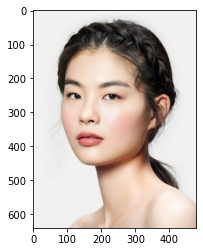

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
### Object detection 기술을 이용해서 얼굴의 위치를 찾겠습니다. 
### Hog(histogram of oriented gradient) -> SVM (sliding window) 이용

In [5]:
import dlib

###  목표는 해당 픽셀이 이를 직접 둘러싸고 있는 픽셀들과 비교해서 얼마나 어두운지 알아내는 것입니다. 이를 통해서 이미지가 어두워지는 방향을 나타내는 화살표를 그리고자 합니다:   ( 그래디언트로 변환)
### 전체 이미지에서 밝은 부분으로부터 어두운 부분으로의 흐름을 알

### dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

In [6]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언


### detector를 이용해서 얼굴의 bounding box를 추출합니다
### detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 이미지 피라미드에 대한 내용은 아래 링크를 참고해 주세요.

In [7]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)


rectangles[[(52, 171) (319, 439)]]


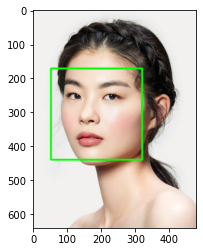

In [8]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 3, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 찾은 얼굴을 화면에 출력해보겠습니

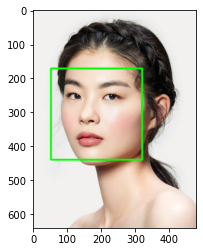

In [9]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### AFLW dataset 21 using
### ibug 300w    68 using


### 저장한 landmark 모델을 불러

In [10]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')


###  landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

In [11]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### 랜드마크를 영상에 출력

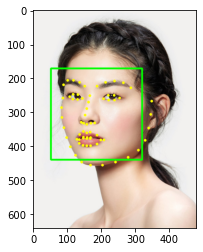

In [12]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 4, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

###  스티커 붙이기 위한 코 중심점 좌표확인

In [13]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] 
#     w = dlib_rect.width()
#     h = dlib_rect.width()
    w = (landmark[30][0] - landmark[36][0])*2
    h = (landmark[48][1] - landmark[2][1])*2
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(152, 308)
(x,y) : (152,308)
(w,h) : (90,128)


### 스티커 이미지를 읽어서 적용해 보

### 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

(128, 90, 3)


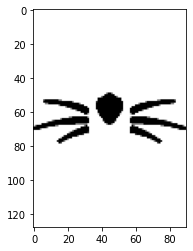

In [14]:
img_sticker = cv2.imread('camera_sticker/images/cat-whiskers.png')
img_sticker = cv2.resize(img_sticker, (w,h))
img_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [15]:
refined_x = x -w//2  # left
refined_y = y - h//2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (107,244)


In [16]:
x_shape = img_sticker.shape[0]
y_shape = img_sticker.shape[1]
print('(x_shape,y_shape) : (%d,%d)'%(x_shape, y_shape))

sticker_area = img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]
img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

(x_shape,y_shape) : (128,90)


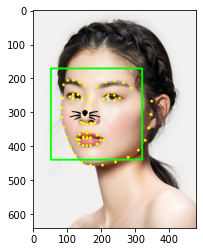

In [17]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

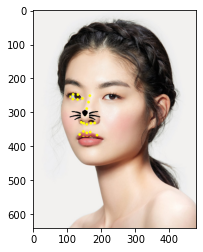

In [18]:
sticker_area = img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]
img_bgr[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (107,0)


### top 의 y 좌표는 원본 이미지의 경계 값으로 수정합

### 원본 이미지에 스티커를 적용합니

In [20]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

In [21]:
# center = np.mean([shape_np[5], shape_np[2]], axis=0).astype(int)
# size = int(np.linalg.norm(shape_np[5] - shape_np[2]) * 1.8)
    
# resized = cv2.resize(glasses.copy(), dsize=(glasses_size, glasses_size))


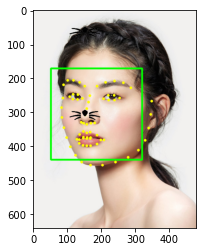

In [22]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#print(landmark[30])

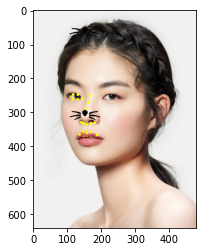

In [23]:
sticker_area = img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]
img_bgr[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 사람얼굴  landmark 로 여러가지 응용서비스가 나올수있으리라는 생각이다. 개 고양이 등 동물도 landmark 가 별도로있을것이니 동물관련 컨텐츠도 개발할수있을듯하다. 이미 여러 데보버전이 나와있다..
### 컨텐트를 원본이미지에 입히는 작업에 대한 연습을 해야할듯하다

### 컨텐츠의 붙여야하는 중심위치 잡는게 익숙치않아 힘들어서..

### 검색해보니 개, 고양이, 곰의 랜드마크가 트레이닝된 DAT파일을 찾아서 곰의 얼굴에 안경을씌우는 것을 해봤다. 곰과 개는 비슷한 얼굴모양이므로 개의 DAT 파일을 곰의 얼굴에도 적용이 가능하다.         곰이 고개를 숙일때 안경도 같이 숙여져야하는데 이 부분에대한 연구가 필요한듯하다..

In [24]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import dlib, cv2, os
from imutils import face_utils
import numpy as np

import matplotlib.pyplot as plt

In [25]:

predictor = dlib.shape_predictor('models/landmarkDetector.dat')

detector = dlib.cnn_face_detection_model_v1('models/bearface_network.dat')


### Load Image

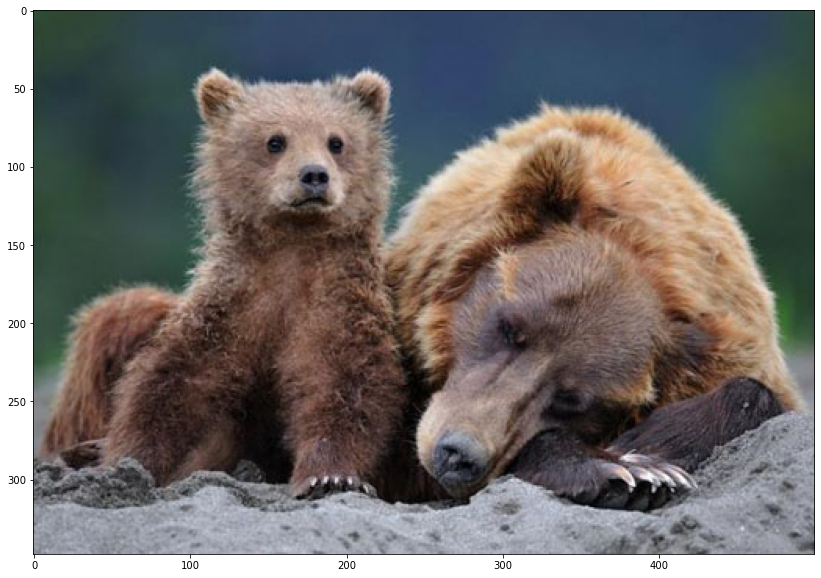

In [26]:
img = dlib.load_rgb_image('bear.jpg')
img_result = img.copy()

plt.figure(figsize=(16, 10))
plt.imshow(img)

# Prediction

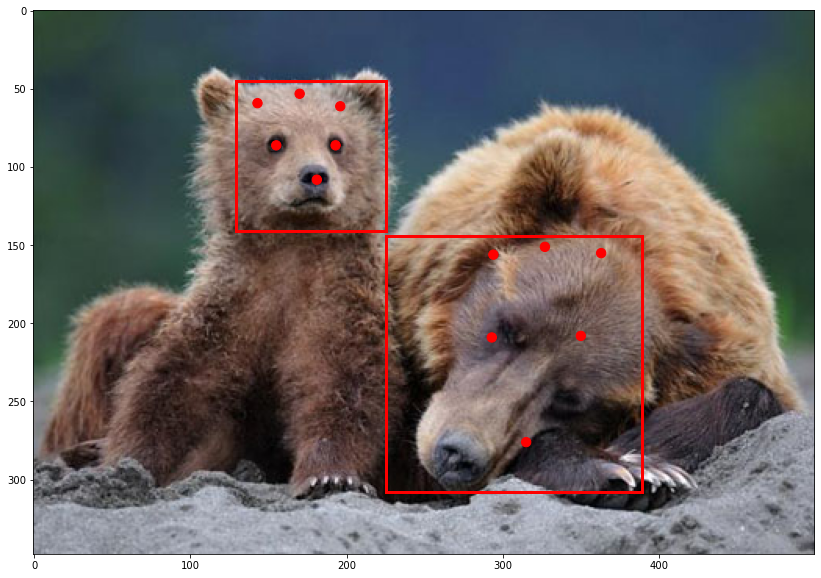

In [27]:
dets = detector(img)

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()
    # 사각형 네모 설정
    
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
    # 바운딩박스 만들어
    ax.add_patch(rect) # 붙임.
    
    shape = predictor(img, det.rect) # land mark  구함

    for point in shape.parts(): # 점들을 구함
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

### Multiple images

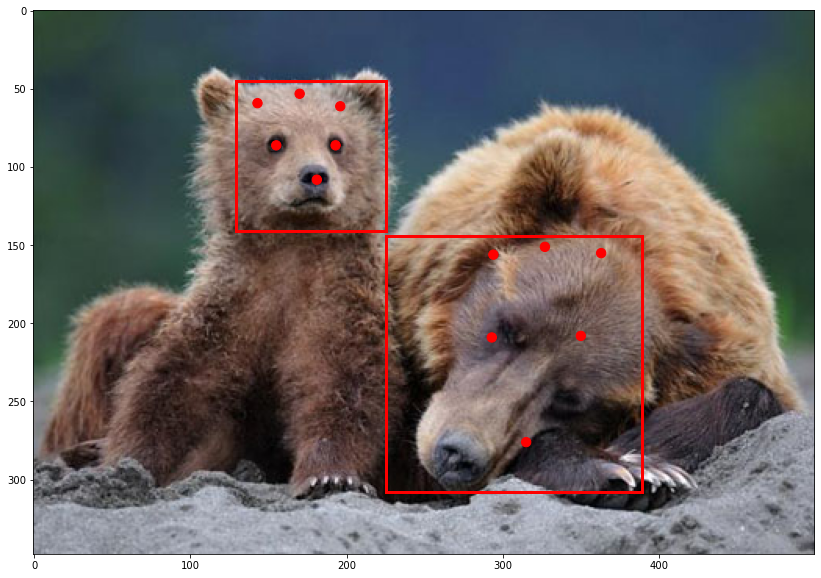

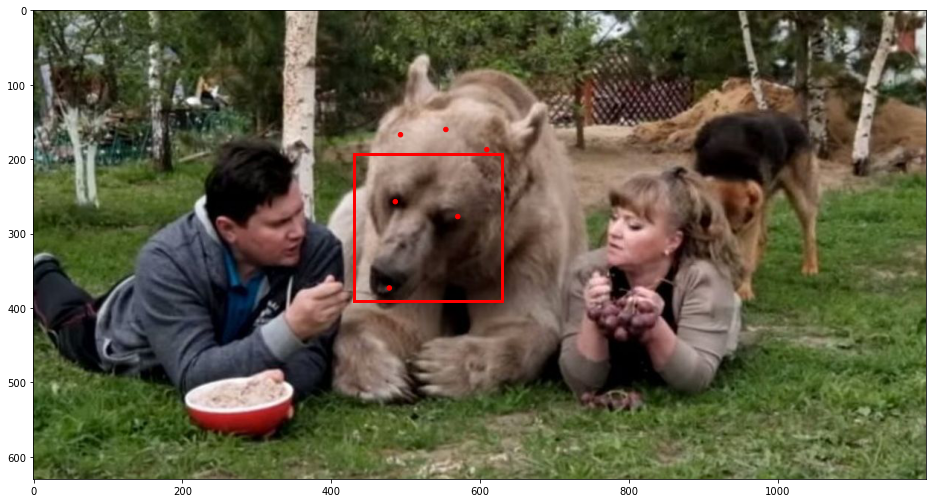

In [28]:
from glob import glob

for img_path in glob('bear*.jp*g'):
    img = dlib.load_rgb_image(img_path)
    img_result = img.copy()

    dets = detector(img)

    fig, ax = plt.subplots(1, figsize=(16, 10))

    for det in dets:
        x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()

        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        shape = predictor(img, det.rect)

        for point in shape.parts():
            circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
            ax.add_patch(circle)

    ax.imshow(img_result)

## put glass

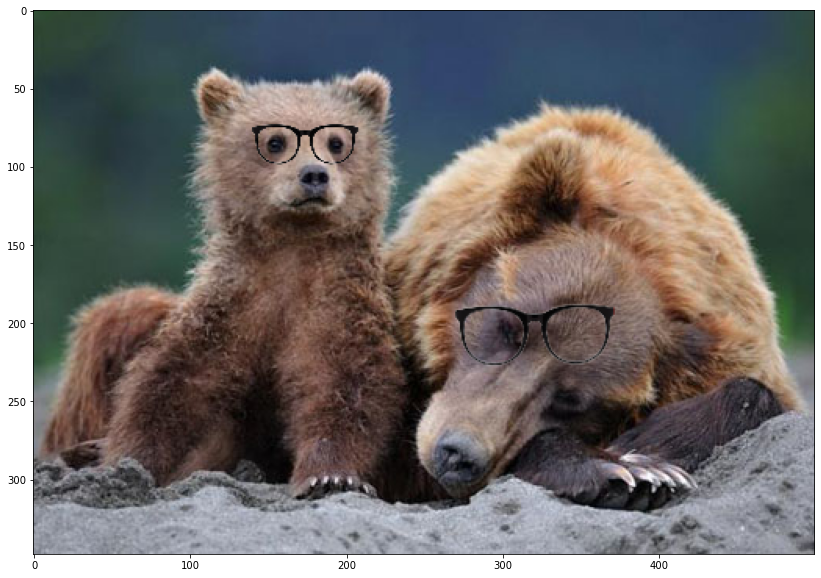

In [32]:
import numpy as np
import cv2
from imutils import face_utils  # shape를 numpy array로 변환.
from math import atan2, degrees

img = dlib.load_rgb_image('bear.jpg')
img_result = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2RGBA)

glasses = cv2.imread('glasses.png', cv2.IMREAD_UNCHANGED)
# glasses = cv2.getRotationMatrix2D()
glasses = cv2.cvtColor(glasses, cv2.COLOR_RGB2RGBA)

dets = detector(img)

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()
    
    shape = predictor(img, det.rect)
    shape_np = face_utils.shape_to_np(shape)
    
    glasses_center = np.mean([shape_np[5], shape_np[2]], axis=0).astype(int)
    glasses_size = int(np.linalg.norm(shape_np[5] - shape_np[2]) * 1.8)
    
    glasses_resized = cv2.resize(glasses.copy(), dsize=(glasses_size, glasses_size))

    def angle_between(p1, p2):
        xDiff = p2[0] - p1[0]
        yDiff = p2[1] - p1[1]
        return degrees(atan2(yDiff, xDiff))

    angle = -angle_between(shape_np[5], shape_np[2])
    M = cv2.getRotationMatrix2D((glasses_resized.shape[1] / 2, glasses_resized.shape[0] / 2), angle, 1)
    rotated_glasses = cv2.warpAffine(
        glasses_resized.copy(),
        M,
        (glasses_size, glasses_size),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=255
    )
    
    x_offset, y_offset = glasses_center - np.array([rotated_glasses.shape[1] / 2, rotated_glasses.shape[0] / 2], dtype=int)

    y1, y2 = y_offset, y_offset + glasses_size
    x1, x2 = x_offset, x_offset + glasses_size

    alpha_s = rotated_glasses[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        img_result[y1:y2, x1:x2, c] = (alpha_s * rotated_glasses[:, :, c] + alpha_l * img_result[y1:y2, x1:x2, c])

ax.imshow(img_result)

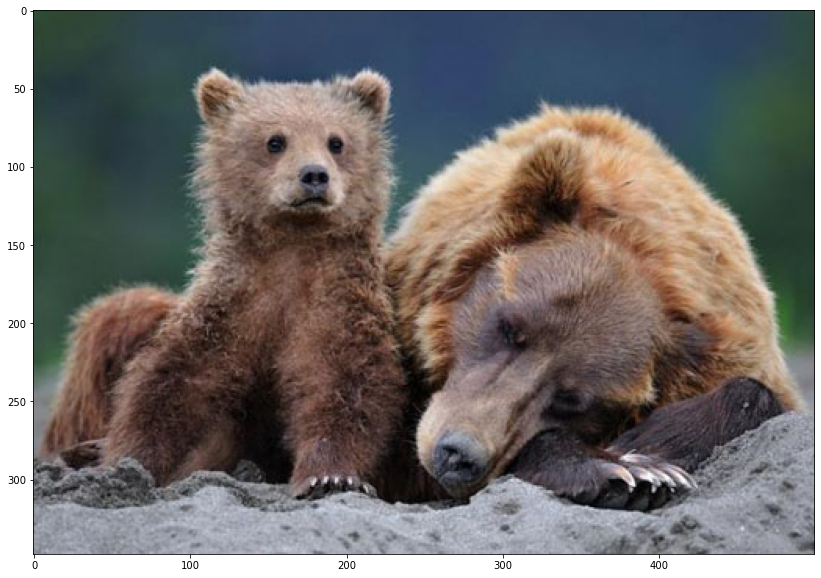

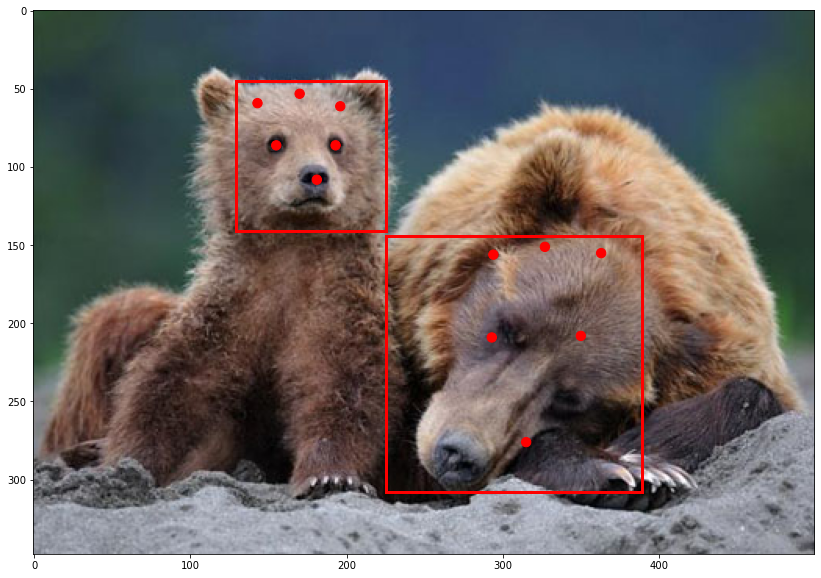

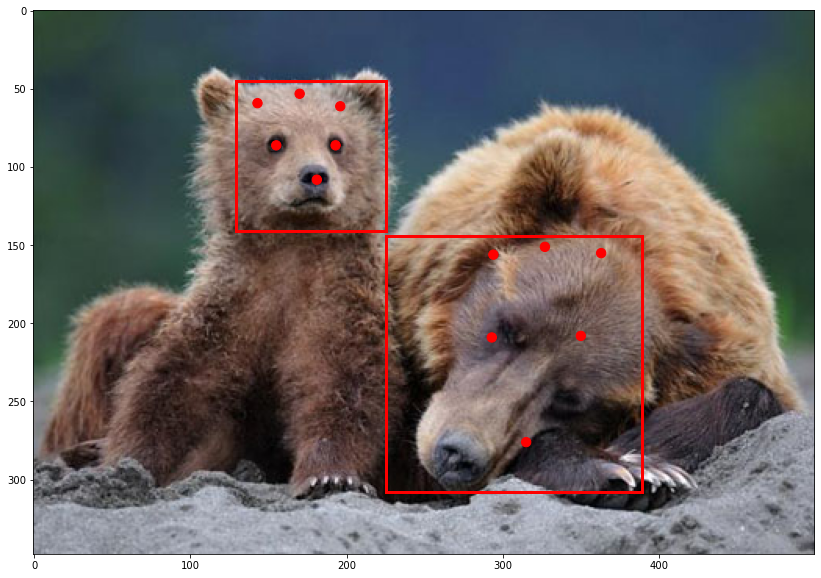

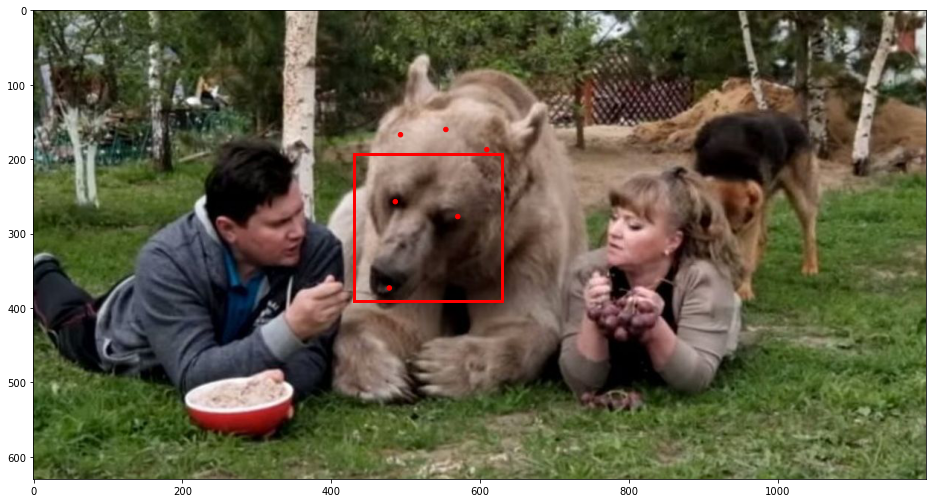

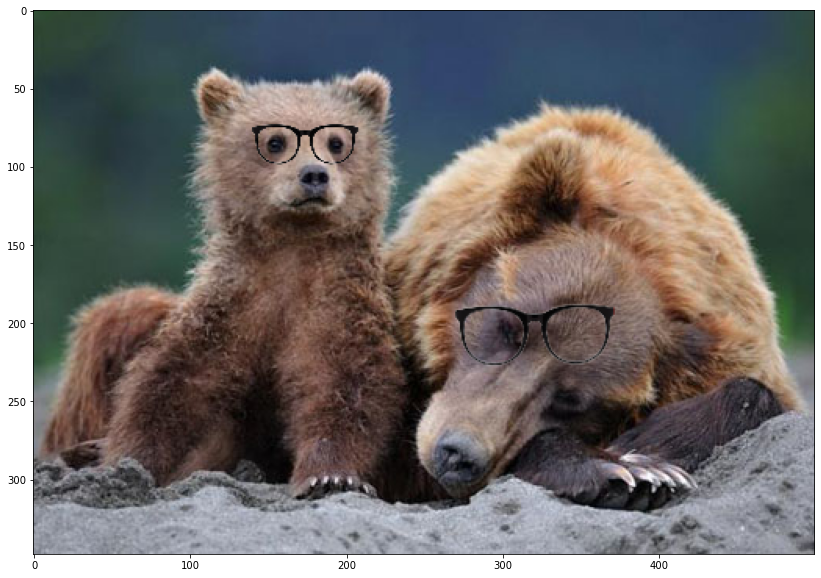

In [30]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import dlib, cv2, os
from imutils import face_utils
import numpy as np

import matplotlib.pyplot as plt


predictor = dlib.shape_predictor('models/landmarkDetector.dat')

detector = dlib.cnn_face_detection_model_v1('models/bearface_network.dat')


### Load Image

img = dlib.load_rgb_image('bear.jpg')
img_result = img.copy()

plt.figure(figsize=(16, 10))
plt.imshow(img)

# Prediction

dets = detector(img)

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()
    # 사각형 네모 설정
    
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
    # 바운딩박스 만들어
    ax.add_patch(rect) # 붙임.
    
    shape = predictor(img, det.rect) # land mark  구함

    for point in shape.parts(): # 점들을 구함
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

### Multiple images

from glob import glob

for img_path in glob('bear*.jp*g'):
    img = dlib.load_rgb_image(img_path)
    img_result = img.copy()

    dets = detector(img)

    fig, ax = plt.subplots(1, figsize=(16, 10))

    for det in dets:
        x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()

        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        shape = predictor(img, det.rect)

        for point in shape.parts():
            circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
            ax.add_patch(circle)

    ax.imshow(img_result)

## put glass

import numpy as np
import cv2
from imutils import face_utils  # shape를 numpy array로 변환.
from math import atan2, degrees

img = dlib.load_rgb_image('bear.jpg')
img_result = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2RGBA)

glasses = cv2.imread('glasses.png', cv2.IMREAD_UNCHANGED)
glasses = cv2.cvtColor(glasses, cv2.COLOR_RGB2RGBA)

dets = detector(img)

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()
    
    shape = predictor(img, det.rect)
    shape_np = face_utils.shape_to_np(shape)
    
    glasses_center = np.mean([shape_np[5], shape_np[2]], axis=0).astype(int)
    glasses_size = int(np.linalg.norm(shape_np[5] - shape_np[2]) * 1.8)
    
    glasses_resized = cv2.resize(glasses.copy(), dsize=(glasses_size, glasses_size))

    def angle_between(p1, p2):
        xDiff = p2[0] - p1[0]
        yDiff = p2[1] - p1[1]
        return degrees(atan2(yDiff, xDiff))

    angle = -angle_between(shape_np[5], shape_np[2])
    M = cv2.getRotationMatrix2D((glasses_resized.shape[1] / 2, glasses_resized.shape[0] / 2), angle, 1)
    rotated_glasses = cv2.warpAffine(
        glasses_resized.copy(),
        M,
        (glasses_size, glasses_size),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=255
    )
    
    x_offset, y_offset = glasses_center - np.array([rotated_glasses.shape[1] / 2, rotated_glasses.shape[0] / 2], dtype=int)

    y1, y2 = y_offset, y_offset + glasses_size
    x1, x2 = x_offset, x_offset + glasses_size

    alpha_s = rotated_glasses[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        img_result[y1:y2, x1:x2, c] = (alpha_s * rotated_glasses[:, :, c] + alpha_l * img_result[y1:y2, x1:x2, c])

ax.imshow(img_result)

In [33]:
 img_sticker.shape

(128, 90, 3)

In [34]:
for dlib_rect,landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = int(math.sqrt((x-landmark[36][0])**2 + (landmark[30][1]-landmark[36][1])**2)*2)
    h = int(math.sqrt((landmark[48][1]-landmark[2][1])**2 + (landmark[48][0]-landmark[2][0])**2)*2)
    print(w, h)
sticker_path = './data/img/cat_nose.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)

# 스티커 이미지 회전
height, width, channel = img_sticker.shape
ang = math.atan(h/w)/math.pi*180
print(ang)
matrix = cv2.getRotationMatrix2D((width/2, height/2), -ang, 1)
img_sticker = cv2.warpAffine(img_sticker, matrix, (width, height))

refined_x = x-w//2
refined_y = y-h//2

x_shape = img_sticker.shape[0]
y_shape = img_sticker.shape[1]

sticker_area = img_bgr[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]
img_bgr[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

(152, 308)


NameError: name 'math' is not defined